# 2022.8.29
- **Paper** Simple Black-Box Adversarial Attacks on Deep Neural Networks
- **Code** Color image watermark embedding
- **Search** Partial area adversarial attack

- Since the watermark is robust, it may resist to some adversarial defense method
- Compare the efficiency between direct gradient attack and wm attack

In [1]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')
# file address in google drive
file_root = './'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def norm_img(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [4]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)

In [5]:
# load and show original image
img = cv2.imread('%sbag2.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [6]:
# load and show watermark image
wm = cv2.imread('%savatar2.jpg'%file_root)
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)
wm = cv2.resize(wm,dsize=(800,800),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

In [7]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=4):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [8]:
# tranform an image from original image to dct blocks
# param bk: a 2-dim numpy array
# param block_size: int
def dct_img(bk,block_size=4):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_dct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_dct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.dct(a_block.astype(np.float64))
    return img_dct

In [9]:
# recover an image from frequency domain to spatial domain
# param bk: a 2-dim numpy array
# param block_size: int
def idct_img(bk,block_size=4):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_idct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_idct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.idct(a_block.astype(np.float64))
    return img_idct

In [10]:
def embed_wm(img,wm,block_size=4,svd=False,alpha=0.2):
    res = np.zeros(shape=(img.shape))
    for ch in range(3):
        i_ch = img[...,ch]
        w_ch = wm[...,ch]
        f_ch = dct_img(i_ch,block_size=block_size)
        w_f_ch = dct_img(w_ch,block_size=block_size)
        if(svd):
            u_ch,s_ch,vt_ch = np.linalg.svd(f_ch)
            s_ch = np.diag(s_ch)
            s_ch = np.pad(s_ch,\
            ((0,img.shape[0]-s_ch.shape[0]),
             (0,img.shape[1]-s_ch.shape[1])),
             mode='constant')
            f_hat_ch = s_ch + alpha*w_f_ch
            _,s_ch_new,_ = np.linalg.svd(f_hat_ch)
            s_ch_new = np.diag(s_ch_new)
            s_ch_new = np.pad(s_ch_new,\
            ((0,img.shape[0]-s_ch_new.shape[0]),
             (0,img.shape[1]-s_ch_new.shape[1])),
             mode='constant')
            f_ch_new = np.dot(np.dot(u_ch,s_ch_new),vt_ch)
        else:
            f_ch_new = f_ch + alpha*w_f_ch
        i_ch_new = idct_img(f_ch_new,block_size=block_size)
        res[...,ch] = i_ch_new
    return res

In [11]:
def extract_wm(wmed_img,img,block_size=4):
    wmed_dct = np.zeros_like(wmed_img)
    img_dct = np.zeros_like(img)
    wm = np.zeros_like(img)
    for ch in range(3):       
        wmed_dct[...,ch] = dct_img(wmed_img[...,ch],block_size=block_size)
        img_dct[...,ch] = dct_img(img[...,ch],block_size=block_size)
        wm[...,ch] = idct_img(wmed_dct[...,ch]-img_dct[...,ch])
    return wm

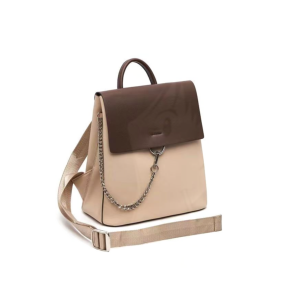

In [12]:
# img_yuv = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
# wm_yuv = cv2.cvtColor(wm,cv2.COLOR_RGB2YUV)
# img_u_dct = dct_img(img_yuv[...,1])
# alpha=0.1
# wmed_u_dct = img_u_dct + 0.1*wm_yuv[...,1]
# wmed_u = idct_img(wmed_u_dct)
# wmed_img_yuv = img_yuv.copy()
# wmed_img_yuv[...,1] = wmed_u
wmed_img = embed_wm(img,wm,svd=False,alpha=0.05)
#wmed_img = cv2.cvtColor(wmed_img_yuv.astype(np.float32),cv2.COLOR_YUV2RGB)
wmed_img = np.clip(wmed_img,0,255)
pltshow(norm_img(wmed_img))

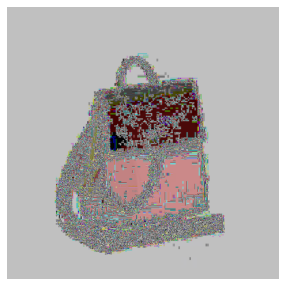

In [13]:
wm_extract = extract_wm(wmed_img,img)
pltshow(wm_extract)

In [14]:
img_beagle = cv2.imread('%sbeagle0.jpg'%file_root)
img_beagle = cv2.cvtColor(img_beagle,cv2.COLOR_BGR2RGB)
wm_beagleresize = cv2.resize(wm,dsize = (960,1280))

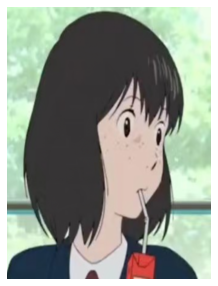

In [18]:
wmed_beagle = embed_wm(img_beagle,wm_beagleresize,svd=False,alpha=0.1)
pltshow(norm_img(10*(wmed_beagle-img_beagle)))

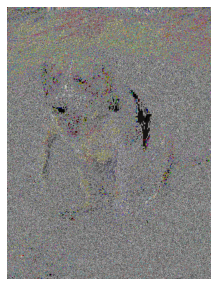

In [16]:
extracted_wm = extract_wm(wmed_beagle,img_beagle)
pltshow(norm_img(extracted_wm))